<a href="https://colab.research.google.com/github/juandmantilla/Prediccion-LQI-RSSI-series-de-tiempo/blob/master/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIMENTOS AUTOMATIZADOS

En este notebook se tratará de automatizar los procesos para la evaluación de los algoritmos de RF, SVR ARIMA y LSTM.


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Carga de Modelos ----------------------
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

# ----------------------------- Carga de herramientas -----------------
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

# ----------------------------------------------------------------------




# Función que retorna un dataframe según las condiciones de nodeId y SrcNode
def cargarDatos(direccion, nodeId, SrcNode):
    df = pd.read_csv(direccion)
    df = df.loc[df['NodeId'] == nodeId]
    df = df.loc[df['SrcNodeId'] == SrcNode ]
    return df


# Función que realiza la diferencia entre una observación en el tiempo t con respecto a
# otra en el tiempo t-1. Los valores que corresponden a cero serán cambiados a 0.5 para
# evitar posibles indeterminaciones en el cálculo de erroes. 
def diferenciarSerie(datos, indicador):
    a = datos[[indicador]].diff(periods = 1).values
    a[0] = a[1]
    fecha = datos[["Date"]].values
    
    b = np.concatenate((fecha, a), axis = 1)
    
    datos = pd.DataFrame(data = b, columns=["Date", indicador])
    
    # Cambio de valores con 0 para evitar indeterminaciones
    datos.loc[datos[indicador] == 0, indicador] = 0.5
    return datos
  

# Función que genera una serie de tiempo de promedios móviles. La ventana móvil
# indicada es de 5 observaciones temporales.
def promediarSerie(datos, indicador):
    datos = datos.rolling(2).mean()
    datos[indicador].fillna(0.5, inplace = True)
    return datos
    

# Función que genera 2 subconjuntos de datos. 
# * dataX corresponde a las observaciones X_t = Y_t-1
# * dataY corresponde a las observaciones en el tiempo t
def unPaso(datos, indicador):    
    dataX = np.array([])
    dataY = np.array([])
    
    for i in range(len(datos.values)):
        dataX = np.append(dataX, datos[[indicador]].values[i-1])
        dataY = np.append(dataY, datos[[indicador]].values[i])
    
    dataX[0] = 0
    
    return dataX, dataY


# Función que genera 2 subconjuntos de datos.
# * dataTransform[:, :-1] es una arreglo bidimensional que contiene los  t-n observaciones anteriores a t.
# * dataTransform[:, -1] es un arreglo unidimensional que contiene las observaciones en un tiempo t.
# Este algoritmo es basado en el recurso en línea: 
# https://stackoverflow.com/questions/48967169/time-delay-embedding-of-time-series-in-python
def multiplesPasos(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      # tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos + 1  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
    
    return dataTransform[:, :-1], dataTransform[:, -1]




#---------------------------------------------DEFINICIÓN DE MODELOS ------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------


# Función modeloRF realiza pretratamiento de datos genera; conjuntos de entrenamiento y prueba,
# el modelo de Random Forest Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor
def modeloRF(dataX, dataY, pasos, diferenciada, datosOriginales, indicador, porcentaje):

  # Generando el conjunto de datos. 80% de entrenamiento. Recuerde que shuffle indica que los valores
  # no se muevan aleatoriamente en el conjunto de datos
  fc = 0
  dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

  random = RandomForestRegressor(n_estimators=250, criterion = "mse",oob_score= True, max_depth = 150)
    
  pred = 0
    
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler, y_train)
    y_test =  invertirEscala(scaler, y_test)
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler2, y_train)
    y_test =  invertirEscala(scaler2, y_test)
        
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):

    fc = x_train.shape[0]
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i -1 ]
      b = np.append(b, a) 
        
    pred = b
    

    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]
    
  # Con pasos y diferenciada
  elif((pasos > 1) and diferenciada == True):
  # Suma de numeros de filas y columnas para el desplazamiento
    fc = x_train.shape[0] + x_train.shape[1]
        
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train



# Función modeloSVM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de Support Vector Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR
def modeloSVM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador, porcentaje):

  dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

  svr = SVR(kernel="rbf", gamma="scale")
  pred = 0
  fc = 0
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler, y_train)
    y_test =  invertirEscala(scaler, y_test)
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler2, y_train)
    y_test =  invertirEscala(scaler2, y_test)
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):

    fc = x_train.shape[0]

    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):  
      a = pred[i] + datosOriginales[indicador].values[fc + i -1]
      b = np.append(b, a) 

    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]
    
  # Con pasos y diferenciada
  elif(pasos > 1 and diferenciada == True):
    fc = x_train.shape[0] + x_train.shape[1]
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train


# Función modeloARIMA realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de ARIMA, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de prueba, regresiones (renombrado como predicciones)

# Este algoritmo es basado en el recurso en línea: 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def modeloArima(datos, pasosTemp ,pasosDif ,indicador, porcentaje):
    
    datos = datos[[indicador]].values
    datos = datos.astype("float32")
    
    # Creando conjunto de entrenamiento y prueba
    num = 1 - int(len(datos)*porcentaje)

    entrenamiento, prueba = datos[:num], datos[num:]

    # Como por cada observación y posterior proyección se debe analizar observaciones anteriores, entonces se debe
    # entrenar el modelo para cada observacion proyectada

    #Copia de entrenamiento. Ese arreglo guarda valores nuevos del arreglo de prueba.
    #Para garantizar que el modelo ARIMA se entrene con los valores posteriores a las observaciones de entrenamiento
    h = [i for i in entrenamiento]

    predicciones = []

    #Por cada observación de prueba se genera la proyección con respecto a las observaciones de test
    for i in range(len(prueba)):

        # --> Parámetros de ARIMA (p, d, q).
        # p: Indica la cantidad de observaciones que se tendrán en cuenta para realizar las proyecciones.
        # d: Indica la cantidad de pasos en la cual se aplica la diferencia en la serie temporal
        # q: Indica el tamaño de la ventana del promedio móvil.
        modeloArima = ARIMA(h, order=(pasosTemp, pasosDif, 0))
        modeloEntrenado = modeloArima.fit(disp = 0, trend = "nc" )

        # Predicción de observación para la observación t+1 de entrenamiento
        salida = modeloEntrenado.forecast()

        predTime = salida[0]
        predicciones.append(predTime)

        #Obteniendo valor real de la observación en tiempo t+1
        obs = prueba[i]

        #Añadiendo al vector para que se entrene nuevamente con este valor en la siguiente iteración.
        h.append(obs)

    return prueba, predicciones, num


# Función para arreglos unidimensionales. Función para transformar el dominio
# de los datos. Retorna datos escalados con su respectivo escalador (scaler).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
def cambiarEscala(dataX, dataY, pasos):
  if (pasos == 1):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX.reshape(-1, 1))

    dataX = dataX.reshape(-1, 1)
    dataX = scaler.transform(dataX)

    dataY = dataY.reshape(-1, 1)
    dataY = scaler.transform(dataY)
    
    scaler2 = 0

  elif (pasos > 1):

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX)

    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    scaler2 = scaler2.fit(dataY.reshape(-1, 1))

    dataX = scaler.transform(dataX)
    dataY = scaler2.transform(dataY.reshape(-1, 1))

  return dataX, dataY, scaler, scaler2


# Función de inversión de escala de datos, retorna datos en el dominio original 
def invertirEscala(scaler, datos):
    datos = scaler.inverse_transform(datos)
    return datos


# -------------------------------------- MODELO LSTM  ----------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------


# Función modeloLSTM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de red LSTM, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
def modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,
              numNeuronas, batch_size, numEpoc, porcentaje):
  fc = 0
  pred = np.array([])
  y_test = np.array([])

  # 1 pasos sin diferenciar ----------------------------------------------------
  if ((pasos == 1) and diferenciada == False):

    # Generando el conjunto de datos. 60% de entrenamiento. Recuerde que shuffle indica que los valores
    # no se muevan aleatoriamente en el conjunto de datos
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25,input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict) 
    y_test = invertirEscala(scaler, y_test)

    # Preparar datos de entrenamiento y prueba para más pasos.

  # Pasos sin diferenciar ----------------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == False):
    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    y_test = invertirEscala(scaler2, y_test)
    

  # 1 paso y diferenciada ---------------------------------------------------------------------------
  elif ((pasos == 1) and diferenciada == True):
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    fc = x_train.shape[0]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    #y_test = invertirEscala(scaler, y_test)

    
    #Transformar datos para el dominio original
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  # Pasos y diferenciada --------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == True):

    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas,dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

   

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    #y_test = invertirEscala(scaler2, y_test)
    
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i -1]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train



#---------------------------------------ERRORES---------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------


# Función errores retorna los diferentes métricas de error con respecto
# a los datos de prueba y las predicciones.
def errores(y_test, pred):

  # Función mean_absolute_percentage_error es basado en el recurso en línea:
  # https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
  def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


  MSE =  round(mean_squared_error( y_test.reshape(-1, 1) , pred), 3)
  MAPE = round( mean_absolute_percentage_error(y_test.reshape(-1, 1), pred) , 3)
  MAE =  round( mean_absolute_error(y_test.reshape(-1, 1), pred), 3)
  MedianAE = round( median_absolute_error(y_test.reshape(-1, 1), pred), 3)
  maxError = round(max_error(y_test.reshape(-1, 1), pred), 3)
  r2 =   round(r2_score(y_test.reshape(-1, 1), pred), 3)

  return MSE, MAE, MAPE, MedianAE, maxError,r2 


  
#-----------------------------------------MOSTRAR SERIE-------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
cont = 0

# Función que grafica la serie temporal predicha
def mostrarSerie(datosOriginales,  y_train, pred, indicador, modelo, pasos, diferencia):
  plt.plot(datosOriginales[["Date"]][ y_train.shape[0]: y_train.shape[0] + pred.shape[0] ], pred, label = modelo )
  global cont
  if (cont == 0):
    num = y_train.shape[0]
    plt.axvline(x = datosOriginales[["Date"]][num: num + 1].values, linestyle='--', color = "plum", label= "Test")
    cont = cont + 1
  elif ( cont >= 1 ):
    cont = cont + 1
    if (cont == 3):
      cont = 0

    
# Función que grafica la serie temporal predicha realizada por el modelo ARIMA
def mostrarSerieARIMA(datosOriginales, pred, num, indicador, modelo):
  plt.plot(datosOriginales[["Date"]][num:], pred, label = modelo)
  

# Función que asigna los títulos, etiquetas y demás a la gráfica de la serie temporal
def labelSerie(datosOriginales, indicador, pasos):
  #Imprimir serie temporal real
  plt.plot(datosOriginales[["Date"]], datosOriginales[[indicador]].values, color="dimgray", label = "Original", alpha = 0.7)
  plt.legend()

  num = int (len(datosOriginales[[indicador]])*0.55)
  #array = [datosOriginales[["Date"]].values[num], datosOriginales[["Date"]].values[-1]]
  #plt.xlim(array)
  #plt.ylim([-20, 0])

  #Título y subtítulo del gráfico
  plt.title("Node " + str(nodeId) + " - " + str(SrcNode) )
  plt.suptitle("Timestep : " + str(pasos))
  plt.xlabel("Timestamp")
  plt.ylabel(str(indicador))
    

#-----------------------------------------DIAGRAMAS DE CAJAS-----------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

def cajasBigotes(RF, SVM, ARIMA, LSTM):
  plt.figure(figsize=(15, 5))
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  ARIMA = np.array(ARIMA).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, ARIMA, LSTM), sym="o", labels=["RF", "SVM", "ARIMA", "LSTM"])

def cajasBigotes2(RF, SVM, LSTM):
  plt.figure(figsize=(15, 5))
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, LSTM), sym="o", labels=["RF", "SVM", "LSTM"])


#----------------------------------------- PRUEBA DE AUTOCORRELACIÓN---------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que grafica la serie temporal correlacionada consigo misma.
# Este algoritmo está basado en el recurso en línea : 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html

def correlacionarSerie(datos):
  autocorrelation_plot(datos)


#----------------------------------------- REALES VS PREDICHOS---------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que grafica en un plano los valores reales de la serie de tiempo vs los valores predichos

def realesPredichos(pred, y_test, modelo, i, ax):
  ax[i].scatter(pred, y_test)
  ax[i].title.set_text(modelo)
  ax[i].set_xlabel("Predicho")
  ax[i].set_ylabel("Real")

#----------------------------------------- HISTOGRAMA ERROR------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que imprime en pantalla los errores de cada modelo.

  




## **Prueba Dickey-Fuller**

La prueba de Dickey-Fuller aumentada puede utilizarse para **comprobar la raíz unitaria** en un proceso univariado en presencia de una correlación en serie.

---
**Hipótesis nula (H0):** Si no se rechaza, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que **no es estacionaria**. Tiene una estructura dependiente del tiempo.
    
**Hipótesis Alternativa (H1):** La hipótesis nula es rechazada; sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que **es estacionaria** . No tiene una estructura dependiente del tiempo.

---

Valor ***p > 0,05:*** Si no se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.
  
Valor ***p <= 0,05:*** Rechazar la hipótesis nula (H0), el dato no tiene una raíz unitaria y es estacionario.

In [19]:
# Este algoritmo está basado en los recursos en línea : https://machinelearningmastery.com/time-series-data-stationary-python/ y en
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

def pruebaDickeyFuller(datos):
  print("---------------------- DICKEY - FULLER ----------------------")
  resultado = adfuller(datos)
  print("ADF Estadistico: %f" % resultado[0])
  print("Valor p: %f" % resultado[1])
  print("Valores críticos")
  for key, value in resultado[4].items():
      print('\t%s: %.5f' % (key, value))
  print("-------------------------------------------------------------")

# **FUNCIÓN EJECUTAR MODELOS**

In [20]:
#Parámetro diferencia hace referencia a un booleano para indicar si la serie que se usa es diferenciada
# dataX, dataY, pasos, diferenciada, datosOriginales, indicador
a = 0
def ejecutarModelos(diferencia, promediada, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos ):
    
    #Guarda en variable los datos cargados. Evitar cargar varias veces.
    datos = cargarDatos(path, nodeId, SrcNode)
    
    
    #Diccionarios que guardan los errores de los modelos
    dicRF = {}
    dicSVM = {}
    dicARIMA = {}
    dicLSTM = {}

    #--------------- PRUEBA DE AUTOCORRELACIÓN y DICKEY - FULLER---------------------------------

    # Resultados de la prueba de Dickey-Fuller a la serie temporal original
    
    serie = datos.values[:, -1]

    pruebaDickeyFuller(serie)

    plt.figure(figsize=(15, 5))
    correlacionarSerie(serie)

    #---------------------------------------------------------------------------------------------


    if (diferencia == False and promediada == False ):
        print ("----------------------- SIN DIFERENCIAS ---------------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1 ):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = unPaso(datos, indicador)    #----> Sólo para RF Y SVM
                
                #Creación de objeto plt
                plt.figure(figsize=(15, 5))
                                
                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                
                                
                ARIMA = modeloArima(datos, i, 0, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                                
               # modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,numNeuronas, batch_size, epochs):
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                
                #labelSerie imprime el títulos, label y timestap
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                # PREDICHOS VS REALES
                
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                                                
            elif( i > 1 and i <= 5):

                #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                
                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                

                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                

                ARIMA = modeloArima(datos, i, 0, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA" )
                
                                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                
                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM
                
            elif ( i > 5):
            #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                
                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)


                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                
                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

        return dicRF, dicSVM, dicARIMA, dicLSTM
    
    elif (diferencia == True and promediada == False):
        
        print ("-----------------------  SERIE DE DIFERENCIAS -----------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = unPaso(datosML, indicador)    #----> Para RF, SVM Y LSTM

                plt.figure(figsize=(15, 5))
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)

                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                plt.legend("RF")

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                plt.legend("SVM")

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif( i>1 and i<=5):
                
                datosML = diferenciarSerie(datos, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
               
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                
            elif ( i > 5):
                datosML = diferenciarSerie(datos, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
               
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

        return dicRF, dicSVM, dicARIMA, dicLSTM
        
    elif(diferencia == True and promediada == True):
        
        print ("---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie(datosML, indicador)
                datosML = unPaso(datosML, indicador) 

                #datos promediados para ARIMA
                datosProm = promediarSerie(datos, indicador)

                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datosProm, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")

                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                labelSerie(datos, indicador, i)
                
                #Diagramas de cajas
              
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif(i>1 and i<=5):

                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])
                
                #Reales vs Predichos


                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif (i>5):
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                fig.tight_layout()


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])
                
                #Reales vs Predichos


                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

    
        return dicRF, dicSVM, dicARIMA, dicLSTM




# **EJECUCIÓN MODELOS**






# **Distribución Original**

**Valores LQI**


---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.477276
Valor p: 0.544721
Valores críticos
	1%: -3.46873
	5%: -2.87840
	10%: -2.57576
-------------------------------------------------------------
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 20': (14.511, 3.156, 7.744, 2.634, 11.456, -1.456)},
 {'Errores modelo SVR :20': (25.353, 4.3, 10.515, 3.914, 13.087, -3.291)},
 {},
 {'Errores modelo LSTM : 20': (18.366, 3.531, 8.669, 2.687, 11.633, -2.108)})

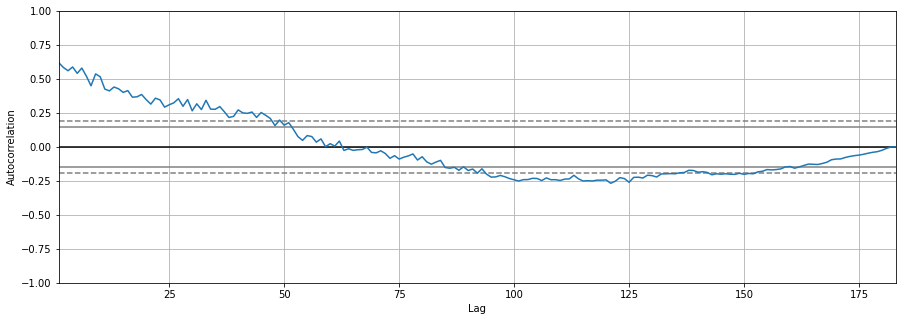

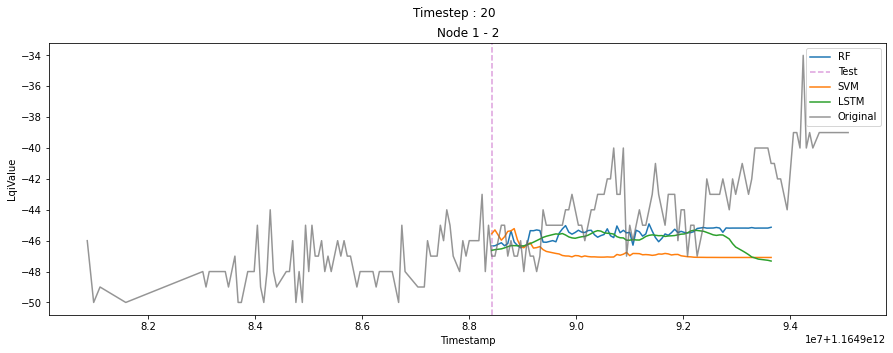

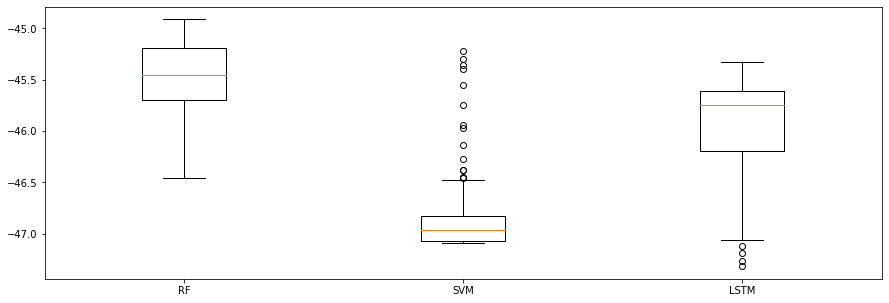

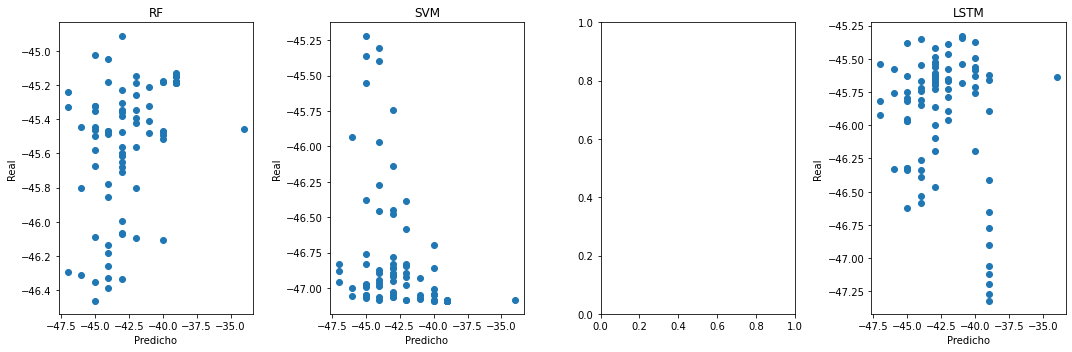

In [21]:
# --> Entrada modelos RF, SVM   dataX, dataY, pasos, diferenciada, datosOriginales, indicador

# --> Entrada ejecutarModelos  diferencia, promediada, path, nodeId, SrcNode, indicador 

#Variables de entrada
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataOriginal.csv"
nodeId = 1
SrcNode = 2
indicador = "LqiValue"
numNeuronas = 64
epocas = 64
porcentajePrueba = 0.5  # <--- 
pasosHistoricos = 20
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentajePrueba, pasosHistoricos)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.477276
Valor p: 0.544721
Valores críticos
	1%: -3.46873
	5%: -2.87840
	10%: -2.57576
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 20': (3.025, 1.282, 6.333, 0.97, 6.078, 0.488)},
 {'Errores modelo SVR :20': (3.038, 1.253, 6.268, 0.919, 6.545, 0.486)},
 {},
 {'Errores modelo LSTM : 20': (2.591, 1.105, 6.158, 0.864, 6.199, 0.562)})

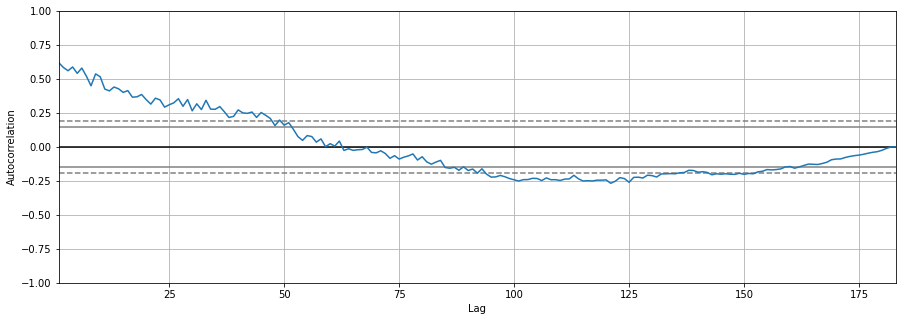

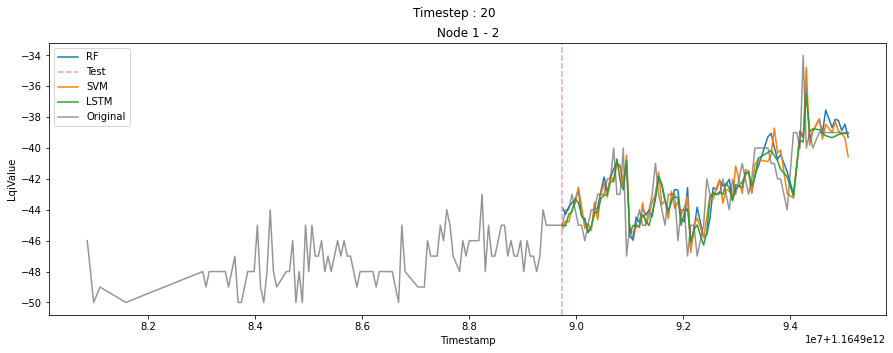

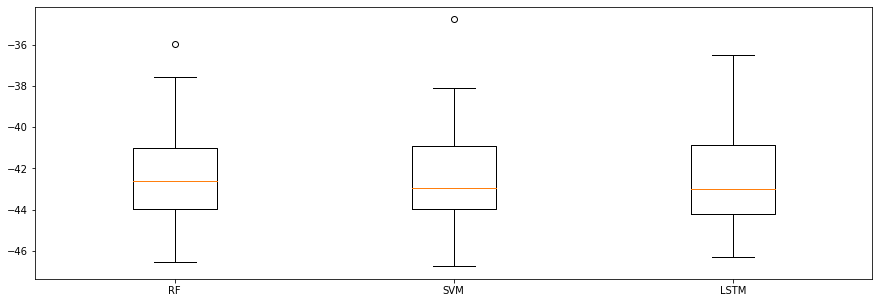

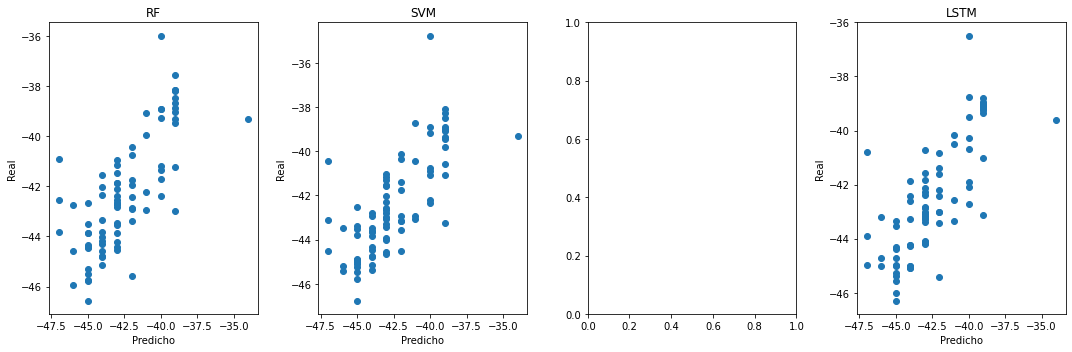

In [22]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas , porcentajePrueba, pasosHistoricos)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.477276
Valor p: 0.544721
Valores críticos
	1%: -3.46873
	5%: -2.87840
	10%: -2.57576
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 20': (3.791, 1.304, 6.403, 0.822, 7.624, 0.358)},
 {'Errores modelo SVR :20': (3.698, 1.294, 6.407, 0.878, 7.79, 0.374)},
 {},
 {'Errores modelo LSTM : 20': (4.022, 1.343, 6.481, 1.019, 7.97, 0.319)})

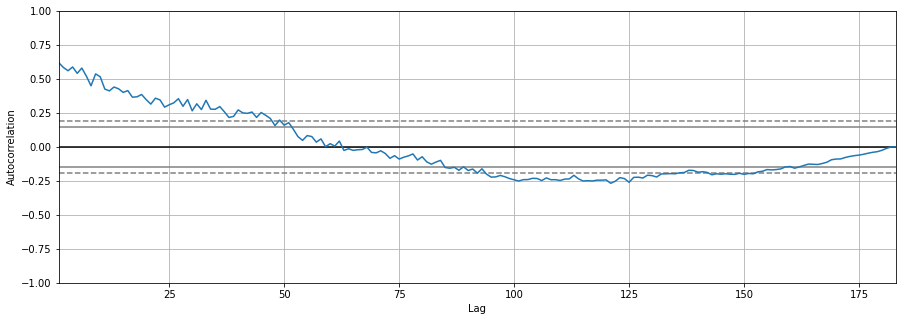

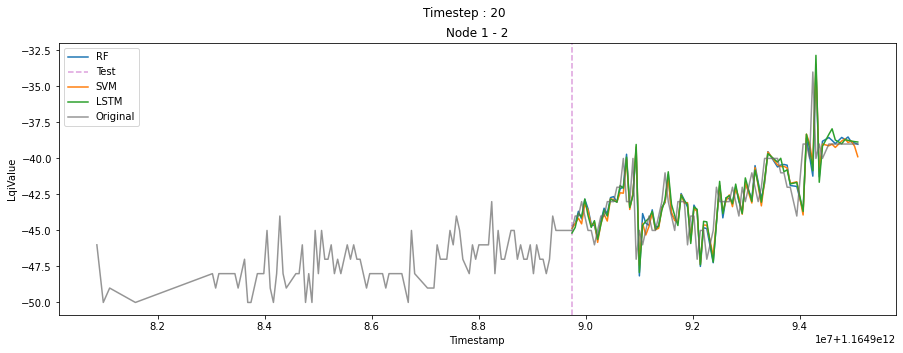

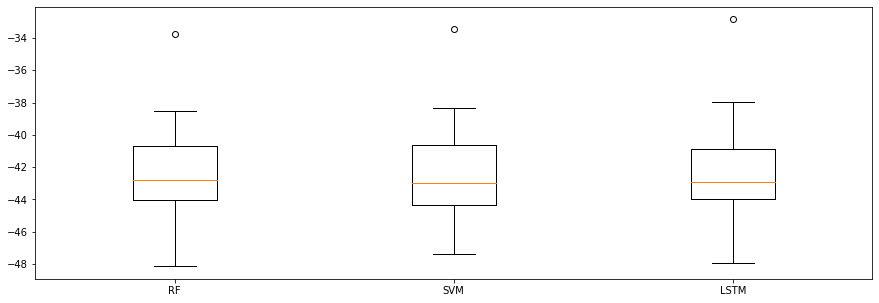

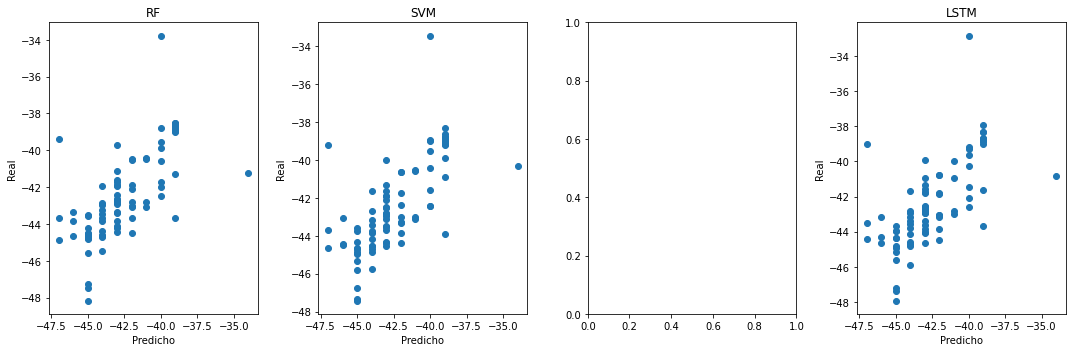

In [23]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentajePrueba, pasosHistoricos)

# **Distribución arimética**

* Datos en orden par son multiplicados por un factor 0.02
* Datos en orden impar son multiplicados por un factor 0.03
* Datos en orden múltiplo de 5 son multiplicados por un factor 0.05

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.45326
	5%: -2.87163
	10%: -2.57215
-------------------------------------------------------------
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opt

({'Errores modelo RF : 4': (12.836, 2.966, 38.088, 2.534, 6.534, -1.705)},
 {'Errores modelo SVR :4': (31.851, 4.314, 56.946, 2.681, 11.767, -5.713)},
 {'Errores modelo ARIMA :4': (2.232, 1.107, 27.268, 0.825, 3.985, 0.529)},
 {'Errores modelo LSTM : 4': (13.341, 3.357, 40.142, 3.279, 6.693, -1.812)})

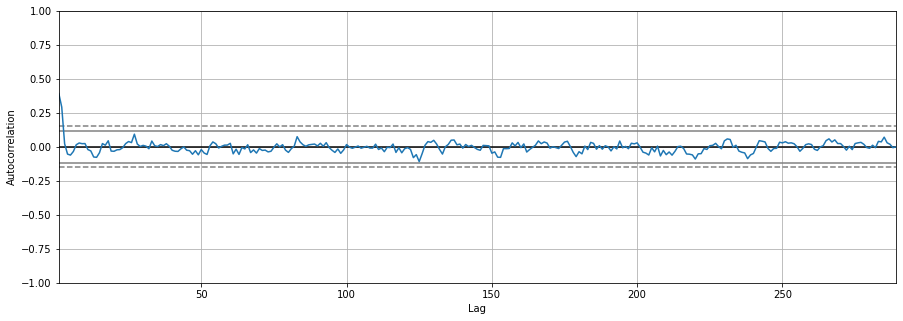

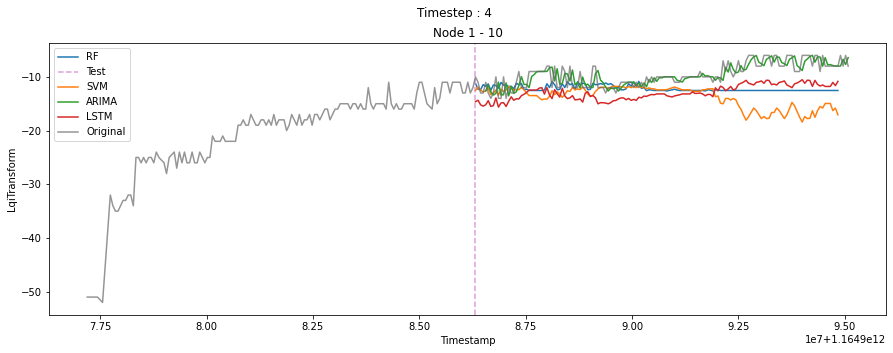

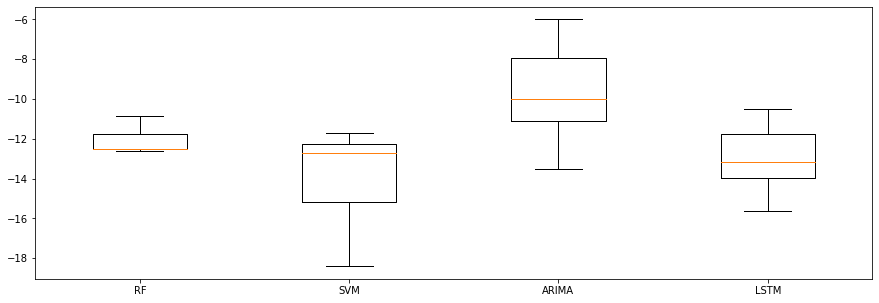

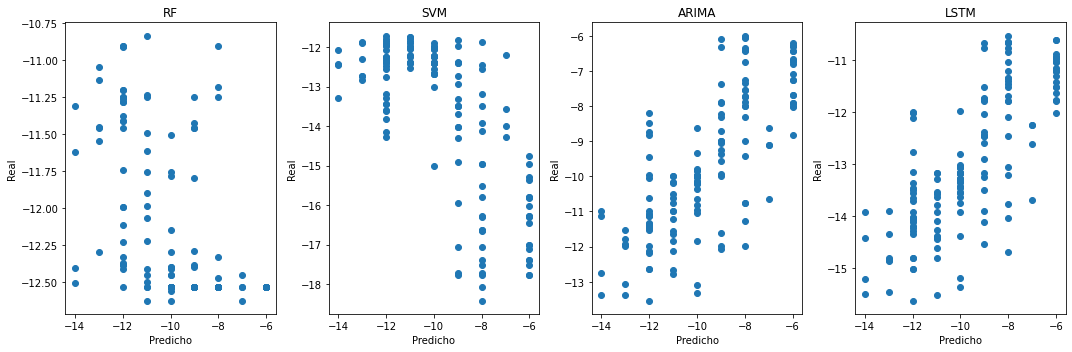

In [24]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 32
epocas = 512
porcentaje = 0.5
pasosHistoricos = 4
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.45326
	5%: -2.87163
	10%: -2.57215
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 4': (2.948, 1.371, 28.08, 1.072, 4.697, 0.379)},
 {'Errores modelo SVR :4': (2.315, 1.16, 26.925, 0.944, 4.328, 0.512)},
 {'Errores modelo ARIMA :4': (2.253, 1.113, 12.495, 0.816, 4.198, 0.525)},
 {'Errores modelo LSTM : 4': (3.754, 1.547, 30.901, 1.264, 5.015, 0.209)})

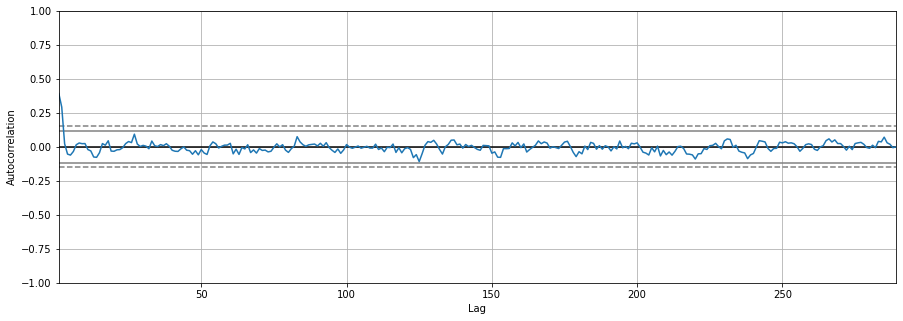

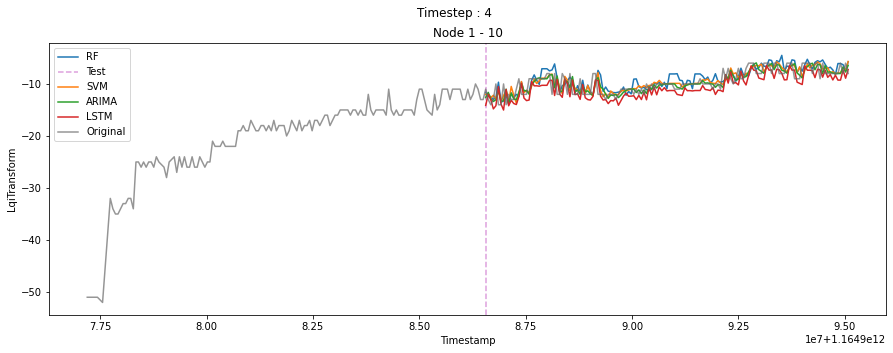

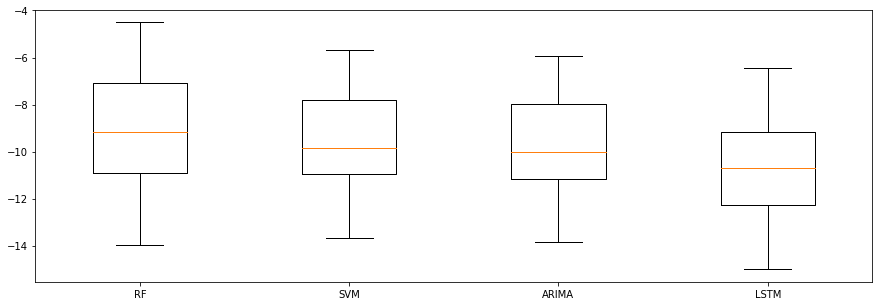

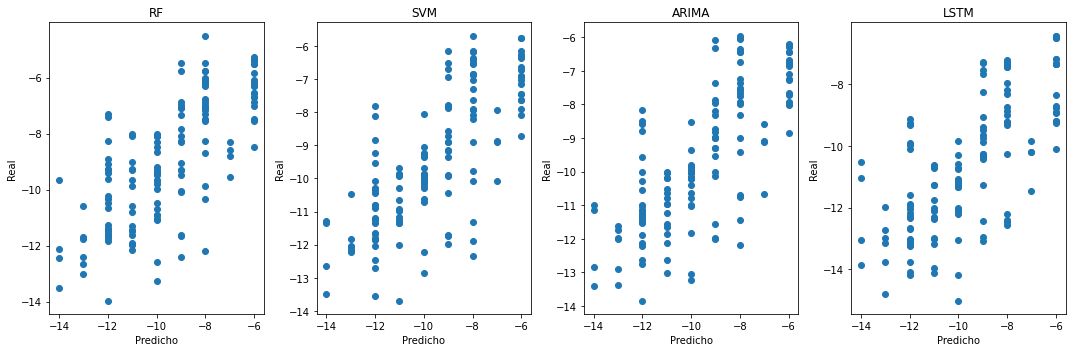

In [25]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos )

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.45326
	5%: -2.87163
	10%: -2.57215
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Distribución Poisson**

* Para LQI
  *   media = 15
  
* Para RSSI
  * media = 210

No acumulado


In [ ]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataPoisson.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 32
epocas = 32
porcentaje = 0.5
pasosHistoricos = 4
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos)

In [ ]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos )

In [ ]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos)